In [1]:
import collections
import csv

import qgrid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import classification_analysis

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Read in the data

We first read in the data: the full dataset, as well as derived files for training the classifiers.

In [2]:
df = pd.read_csv("../data/cad_v1.tsv", delimiter="\t", quoting=csv.QUOTE_NONE,  keep_default_na=False)

In [3]:
print("In total we have %s rows" % len(df))
print("In total we have %s unique entries (-post, -title, comments)" % len(set(df['info_id'])))

In total we have 27494 rows
In total we have 26550 unique entries (-post, -title, comments)


Number of unique entries, posts have a '-post' and '-title' entry but are counted as one for statistics

In [4]:
unique_posts = set()
unique_comments = set()
for index, row in df.iterrows():
    if '-title' not in row['info_id']:
        if '-post' in row['info_id']:
            unique_posts.add(row['info_id'])
        else:
            unique_comments.add(row['info_id'])
        
print("Total number of unique posts: %s" % len(unique_posts))
print("Total number of unique comments: %s" % len(unique_comments))
print("Total: %s" % (len(unique_posts) + len(unique_comments)))

Total number of unique posts: 1394
Total number of unique comments: 23762
Total: 25156


In [5]:
df_train = pd.read_csv("../data/cad_v1_train.tsv", delimiter="\t", quoting=csv.QUOTE_NONE,  keep_default_na=False)
df_dev = pd.read_csv("../data/cad_v1_dev.tsv", delimiter="\t", quoting=csv.QUOTE_NONE,  keep_default_na=False)
df_test = pd.read_csv("../data/cad_v1_test.tsv", delimiter="\t", quoting=csv.QUOTE_NONE,  keep_default_na=False)

How does the data look like?

In [6]:
df.head()

,id,info_id,info_subreddit,info_subreddit_id,info_id.parent,info_id.link,info_thread.id,info_order,info_image.saved,annotation_Primary,...,annotation_Target_top.level.category,annotation_highlighted,meta_author,meta_created_utc,meta_date,meta_day,meta_permalink,split,subreddit_seen,meta_text
0,cad_1,alywla-post,Drama,t5_2rd2l,"""NA""","""NA""",2,02-post,0,Neutral,...,"""NA""","""NA""",RedGT2033,1548999908,2019-02-01T05:45:08Z,2019-02-01T00:00:00Z,/r/Drama/comments/alywla/centrist_daddy_gets_d...,exclude_empty,1,
1,cad_2,am027u-post,conspiracy,t5_2qh4r,"""NA""","""NA""",3,03-post,0,Neutral,...,"""NA""","""NA""",G0LD3NDAWN,1549010283,2019-02-01T08:38:03Z,2019-02-01T00:00:00Z,/r/conspiracy/comments/am027u/what_are_your_op...,test,0,. I just watched a 4 hour long disclosure buff...
2,cad_3,am80hq-post,subredditcancer,t5_2yv5q,"""NA""","""NA""",5,05-post,0,Neutral,...,"""NA""","""NA""",SpecialThrowaway6,1549062528,2019-02-01T23:08:48Z,2019-02-01T00:00:00Z,/r/subredditcancer/comments/am80hq/banned_and_...,exclude_empty,1,
3,cad_4,amcs27-post,Drama,t5_2rd2l,"""NA""","""NA""",9,09-post,0,Neutral,...,"""NA""","""NA""",[deleted],1549101640,2019-02-02T10:00:40Z,2019-02-02T00:00:00Z,/r/Drama/comments/amcs27/at_rworldnews_10_hour...,exclude_empty,1,
4,cad_5,aml76e-post,Drama,t5_2rd2l,"""NA""","""NA""",12,12-post,0,Neutral,...,"""NA""","""NA""",KristenLuvsCATS,1549159930,2019-02-03T02:12:10Z,2019-02-03T00:00:00Z,/r/Drama/comments/aml76e/guy_gets_in_trouble_w...,exclude_empty,1,


## Splits analysis

**How many entries do we exclude? (e.g. because they're empty or written by a prolific bot?)**

In [7]:
df_include = df.loc[df['split'].isin(['train', 'dev', 'test'])]
print("Keep %s, exclude %s" % (len(df_include), len(df) - len(df_include)))

Keep 24292, exclude 3202


**The number of entries in each split**

In [8]:
df["split"].value_counts()

train            14113
test              5495
dev               4684
exclude_empty     2244
exclude_bot        604
exclude_lang       353
exclude_image        1
Name: split, dtype: int64

**For each split, count the number of entries in the subreddits that were seen/unseen during training**

In [9]:
df.groupby('split')['subreddit_seen'].value_counts()

split          subreddit_seen
dev            0                  2782
               1                  1902
exclude_bot    1                   453
               0                   151
exclude_empty  1                  1470
               0                   774
exclude_image  1                     1
exclude_lang   1                   323
               0                    30
test           0                  3568
               1                  1927
train          1                 14113
Name: subreddit_seen, dtype: int64

## Label distribution analysis

Print out the frequencies for each primary category per split

In [10]:
df.groupby(['split','subreddit_seen'])['annotation_Primary'].value_counts()

split          subreddit_seen  annotation_Primary      
dev            0               Neutral                      2126
                               IdentityDirectedAbuse         277
                               AffiliationDirectedAbuse      190
                               PersonDirectedAbuse           137
                               CounterSpeech                  34
                               Slur                           18
               1               Neutral                      1538
                               IdentityDirectedAbuse         188
                               AffiliationDirectedAbuse       89
                               PersonDirectedAbuse            69
                               Slur                           14
                               CounterSpeech                   4
exclude_bot    0               Neutral                       137
                               IdentityDirectedAbuse          10
                               Per

In [11]:
df.groupby(['split'])['annotation_Primary'].value_counts(normalize=True)

split          annotation_Primary      
dev            Neutral                     0.782237
               IdentityDirectedAbuse       0.099274
               AffiliationDirectedAbuse    0.059564
               PersonDirectedAbuse         0.043980
               CounterSpeech               0.008113
               Slur                        0.006832
exclude_bot    Neutral                     0.783113
               IdentityDirectedAbuse       0.074503
               PersonDirectedAbuse         0.072848
               AffiliationDirectedAbuse    0.051325
               Slur                        0.013245
               CounterSpeech               0.004967
exclude_empty  Neutral                     0.940731
               IdentityDirectedAbuse       0.040998
               AffiliationDirectedAbuse    0.010695
               PersonDirectedAbuse         0.005348
               Slur                        0.002228
exclude_image  IdentityDirectedAbuse       1.000000
exclude_lang   Neutral  

In [12]:
df['annotation_Secondary'].value_counts()

"NA"                                                             22084
IdentityDirectedAbuse / animosity                                 1577
IdentityDirectedAbuse / derogation                                1026
AffiliationDirectedAbuse / animosity                               676
AffiliationDirectedAbuse / derogation                              629
PersonDirectedAbuse / directed to a person in the thread           560
PersonDirectedAbuse / about a person who is not in the thread      552
CounterSpeech / identity-directed                                  115
CounterSpeech / affiliation-directed                                53
CounterSpeech / person-directed                                     52
IdentityDirectedAbuse / glorification                               49
IdentityDirectedAbuse / threatening language                        31
AffiliationDirectedAbuse / dehumanization                           31
AffiliationDirectedAbuse / threatening language                     30
Identi

In [13]:
df['annotation_Primary'].value_counts(normalize=True)

Neutral                     0.797810
IdentityDirectedAbuse       0.098640
AffiliationDirectedAbuse    0.049684
PersonDirectedAbuse         0.040445
CounterSpeech               0.008002
Slur                        0.005419
Name: annotation_Primary, dtype: float64

# Read in the splits

In [14]:
num_posts= float(len(df_train) + len(df_dev) + len(df_test))
print("Total number of entries: %s" % num_posts)
print("Train: %s (%.3f); Dev: %s (%.3f); Test: %s (%.3f)" % (len(df_train), len(df_train)/num_posts, 
                                                       len(df_dev), len(df_dev)/num_posts, 
                                                       len(df_test), len(df_test)/num_posts))

Total number of entries: 23417.0
Train: 13584 (0.580); Dev: 4526 (0.193); Test: 5307 (0.227)


Only keep one row per entry

In [15]:
df.drop_duplicates(subset=['info_id'])["split"].value_counts()

train            13584
test              5307
dev               4526
exclude_empty     2211
exclude_bot        568
exclude_lang       353
exclude_image        1
Name: split, dtype: int64

How many neutral entries are there in the test split?

In [16]:
print("Fraction of Neutral posts in test: %.1f" % (100 * len(df_test[df_test['labels']=='Neutral'])/len(df_test)))

Fraction of Neutral posts in test: 81.8


# Context 

annotation_Context indicates whether the annotation depended on previous content. 

In [17]:
df['annotation_Context'].value_counts()

"NA"               21935
CurrentContent      3993
PreviousContent     1566
Name: annotation_Context, dtype: int64

In [18]:
df.groupby(['annotation_Primary'])['annotation_Context'].value_counts()

annotation_Primary        annotation_Context
AffiliationDirectedAbuse  CurrentContent         1033
                          PreviousContent         333
CounterSpeech             PreviousContent         220
IdentityDirectedAbuse     CurrentContent         2046
                          PreviousContent         666
Neutral                   "NA"                  21935
PersonDirectedAbuse       CurrentContent          765
                          PreviousContent         347
Slur                      CurrentContent          149
Name: annotation_Context, dtype: int64

Print out a few entries for which the annotation depended on the previous content

In [37]:
t = 0
for index, row in df.iterrows():
    if row['annotation_Context'] == 'PreviousContent' and row['split'] == "train":
        print("%s\t%s\t%s" % (row['info_id'], row['annotation_Primary'], row['meta_text']))
        t += 1
        if t == 20:
            break

efmlmcc	IdentityDirectedAbuse	Have you guys heard about the butt pizza?  [linebreak]  [linebreak]   [linebreak]  [linebreak]   [linebreak]  [linebreak]   [linebreak]  [linebreak]   [linebreak]  [linebreak]   [linebreak]  [linebreak] It's pretty shit.
efnjb9v	IdentityDirectedAbuse	I hate that I found this funny
efryz1c	IdentityDirectedAbuse	Dont be jelous
efw17ni	IdentityDirectedAbuse	You havent seen those vids of britain where the entire neighborhoods are 100% muslims?
egh0p9t	IdentityDirectedAbuse	What about a butt plug for you?
eghj9fq	IdentityDirectedAbuse	maybe stop sexting gay dudes?
eghqvyj	IdentityDirectedAbuse	That was very halal
eghymnk	IdentityDirectedAbuse	*You have expelled the Jews from r/Drama*
eghyrx6	IdentityDirectedAbuse	This but unironically
egi67x1	IdentityDirectedAbuse	This but unironically.
egj0rz7	PersonDirectedAbuse	Do you tie your own shoes?
egx1tyg	AffiliationDirectedAbuse	Daughter: dad, can you take me to school [linebreak]  [linebreak] Me: sorry sweety, I can

# Info image

Prints the counts for image info

In [20]:
df['info_image.saved'].value_counts() 

0                26933
1                  428
imageNotSaved      133
Name: info_image.saved, dtype: int64

# Bots analysis

In [21]:
df.loc[df['split'] == 'exclude_bot'][["info_id","annotation_Primary", "meta_author", "meta_text"]]

,info_id,annotation_Primary,meta_author,meta_text
957,efk0mta,Neutral,SnapshillBot,[linebreak] [linebreak] Snapshots: [linebreak...
989,efl0iyd,Neutral,SnapshillBot,That was worse than I thought it would be. The...
1052,efm53w9,Neutral,AutoModerator,"[linebreak] Speaking of cancer, Krackajak78......"
1057,efmqz8g,Neutral,SnapshillBot,"You were put down, in the future please refrai..."
1181,efqkrhj,Neutral,SnapshillBot,Gay porn is a genre that cuts across all demog...
...,...,...,...,...
25787,eu7uasi,Neutral,SnapshillBot,Spez is YOUR admin!!!!1 8 more years!!!!1! dea...
25812,eub58pv,PersonDirectedAbuse,SnapshillBot,Are you genuinely mentally challenged? Please ...
25815,eubp4ua,IdentityDirectedAbuse,AutoModerator,[linebreak] Woah there CareBearStare666! Next ...
25976,ejetupi,Slur,AutoModerator,"Your comment has been removed. As of recently,..."


Get stats for the two prolific bots

In [22]:
df.loc[df['meta_author'] == 'SnapshillBot']['annotation_Primary'].value_counts()

Neutral                     236
PersonDirectedAbuse          35
IdentityDirectedAbuse        35
AffiliationDirectedAbuse     31
CounterSpeech                 2
Name: annotation_Primary, dtype: int64

In [23]:
df.loc[df['meta_author'] == 'AutoModerator']['annotation_Primary'].value_counts()

Neutral                  237
IdentityDirectedAbuse     10
PersonDirectedAbuse        9
Slur                       8
CounterSpeech              1
Name: annotation_Primary, dtype: int64

# Text length analysis

Get the unique set of texts and preprocess it

In [24]:
texts = df_include.drop_duplicates(subset=['info_id'])['meta_text'].tolist()
texts =  [s.replace('[linebreak]', "\n").strip() for s in texts]
for text in texts[:2]:
    print("**")
    print(text)

**
. I just watched a 4 hour long disclosure buffet my greer. I honestly have no reason I would doubt him. He had extensive knowledge. His history and accounts are all verifiable. He has incredibly powerful and high up people informing or working with him. This video I'm pretty sure was ten years old have no idea what he's up to these days. I am impressed he just comes out and tells you what he knows and I'm sure the only reason he's Alive is because no one could even make this stuff up. If everything he says is true I don't know how he copes with a reality like that. 
  
 Although Tom DeLonge has some impressive sounding people in his "accadedemy" they are a few very smart people with nice sounding titles Lou Elizando who I admire for wanting to disclose, was only running a program that was disinfo at best. Head of aerospace threat identification program sounds for the Pentagon sounds super impressive but if greer is telling the truth he was a government coffee boy. I would bet my lif

Print the text lenghts (number of chars)

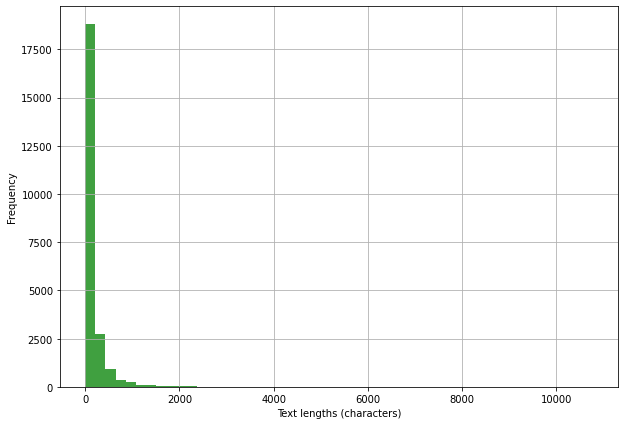

In [25]:
char_lenghts = [len(s) for s in texts]
plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(char_lenghts, 50, facecolor='g', alpha=0.75)

plt.xlabel('Text lengths (characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [26]:
longest_text = ""
for text in texts:
    if len(text) > len(longest_text):
        longest_text = text
        
# multiple spaces removed
print("Length of longest text: %s" % len(" ".join(longest_text.split())))
#print(longest_text)

Length of longest text: 10714


# Rationales

First, print the average rationale length for the primary and secondary categories in the training data.
Neutral doesn't contain rationales (so skip).

In [27]:
# First collect all rationales by category
rats_map_sec = {}
rats_map_prim = {}

# rationale / text length
rats_map_prim_text = {}

for index, row in df.iterrows():
    if row['split'] == "train":
        if row['annotation_Primary'] != 'Neutral':
            
            # Preprocess the data
            rationale = row['annotation_highlighted'].replace('[linebreak]', "\n")
            main_text = row['meta_text'].replace('[linebreak]', "\n")
                
            # Store the rationale by primary cat
            if row['annotation_Primary'] not in rats_map_prim:
                rats_map_prim[row['annotation_Primary']] = [rationale]
                rats_map_prim_text[row['annotation_Primary']] = [len(main_text) - len(rationale)]
            else:
                rats_map_prim[row['annotation_Primary']].append(rationale)
                rats_map_prim_text[row['annotation_Primary']].append(len(rationale)/float(len(main_text)))
            
            # Store the rationale also by secondary cat
            sec_cat = row['annotation_Primary'] + '_' + row['annotation_Secondary']
            if sec_cat not in rats_map_sec:
                rats_map_sec[sec_cat] = [rationale]
            else:
                rats_map_sec[sec_cat].append(rationale)

# Now print out the stats
print("Primary category: rationale length")
for prim_cat, rationales in rats_map_prim.items():
    lengths = np.array([len(s) for s in rationales])
    print("%s\t%.4f\t%s" % (prim_cat, lengths.mean(), len(lengths)))
    
print("\nSecondary category: rationale length")
for sec_cat, rationales in rats_map_sec.items():
    lengths = np.array([len(s) for s in rationales])
    print("%s\t%.4f\t%s" % (sec_cat, lengths.mean(), len(lengths)))
    
print("\nPrimary category: rationale length / main text")
for prim_cat, lengths in rats_map_prim_text.items():
    print("%s\t%.4f\t%s" % (prim_cat, np.array(lengths).mean(), len(lengths)))
    

Primary category: rationale length
AffiliationDirectedAbuse	112.2122	773
PersonDirectedAbuse	86.8434	613
IdentityDirectedAbuse	83.9236	1519
Slur	6.2000	85
CounterSpeech	279.1062	113

Secondary category: rationale length
AffiliationDirectedAbuse_AffiliationDirectedAbuse / derogation	121.2920	339
PersonDirectedAbuse_PersonDirectedAbuse / directed to a person in the thread	85.2737	285
IdentityDirectedAbuse_IdentityDirectedAbuse / animosity	82.5038	913
PersonDirectedAbuse_PersonDirectedAbuse / about a person who is not in the thread	88.2073	328
Slur_"NA"	6.2000	85
IdentityDirectedAbuse_IdentityDirectedAbuse / derogation	84.7996	564
AffiliationDirectedAbuse_AffiliationDirectedAbuse / animosity	106.8454	401
CounterSpeech_CounterSpeech / identity-directed	148.2963	54
CounterSpeech_CounterSpeech / affiliation-directed	642.1613	31
AffiliationDirectedAbuse_AffiliationDirectedAbuse / dehumanization	86.8750	16
CounterSpeech_CounterSpeech / person-directed	129.4286	28
IdentityDirectedAbuse_Identity

For each category, print a few rationales

In [28]:
for primary_cat, rationales in rats_map_prim.items():
    print("\n***%s***" % primary_cat)
    for rationale in rationales[1:10]:
        print(rationale)


***AffiliationDirectedAbuse***
there's a reason why 'addict parents sold me to their friends' is a trope.
watching the left applaud her is like the popular kid in school making a joke that doesn't even make sense but everybody still laughs.
tumblr makes me afraid to go outside in case i get to close to a feminist.
ok i'm afraid to go outside in case i meet a crazy feminist.
that'a true. most women who call themselves feminists are good people who just don't know that the wage gap or inflated rape statistics are bs. they don't hate men and would support men who are raped or assaulted (unlike some of the posts that get shared here of peoppe claiming that men can't be raped.) a lot of them believe basically the same things that i do, that neither men nor women should be discriminated against, violence against anyone is bad, women in poor countries often face the worst of sexism and sexual violence, etc. they just haven't been exposed to the nasty side of feminism, so while i and many peo

# Frequent entries

For each text, count the number of posts that have exactly that text

In [29]:
c = collections.Counter()
processed = set()

# add the entries to a counter
for index, row in df.iterrows():
    text = str(row['meta_text'])
    if 'exclude' not in row['split']:
        if row['info_id'] not in processed:
            c.update({text: 1})
            processed.add(row['info_id'])

# now print most frequent entries
for text, count in c.most_common(10):
    print("%s\t%s" % (count, text))

34	Your post has been removed because it does not contain a [submission statement](https://www.reddit.com/r/conspiracy/comments/7m8q75/submission_statements_now_required_for_all_link/). If you think you received this message in error, or if you have subsequently added a submission statement, please [contact the mods through modmail](https://www.reddit.com/message/compose?to=%2Fr%2Fconspiracy), and include a link to the comment with your submission statement. [linebreak]  [linebreak] ^(This is a bot: replies and PMs will not receive responses.)
29	Cat
11	F
9	Source?
8	Same
8	Based
8	Yes
7	Lol
7	Thank you.
7	Yes.


# Label analysis

Print out label statistics (e.g., for each combination of labels its frequency) in the training set

In [30]:
label_cardinality, label_set_count, pairwise_label_counts = classification_analysis.compute_label_stats(df_train['labels'])

Number of instances: 13584
Number of non-Neutral instances: 2511
Number of instances with >1 label: 264 (1.94%)
Percentage of non-Neutral instances with >1 labels: 10.5

Label cardinality: 1.021
11073	Neutral
1131	IdentityDirectedAbuse
570	AffiliationDirectedAbuse
448	PersonDirectedAbuse
108	IdentityDirectedAbuse PersonDirectedAbuse
98	CounterSpeech
93	AffiliationDirectedAbuse IdentityDirectedAbuse
31	AffiliationDirectedAbuse PersonDirectedAbuse
17	AffiliationDirectedAbuse IdentityDirectedAbuse PersonDirectedAbuse
8	CounterSpeech PersonDirectedAbuse
4	CounterSpeech IdentityDirectedAbuse
3	AffiliationDirectedAbuse CounterSpeech

Pairwise counts
	Neutral	IdentityDirectedAbuse	AffiliationDirectedAbuse	PersonDirectedAbuse	CounterSpeech
Neutral	0.0	0.0	0.0	0.0	0.0
IdentityDirectedAbuse	0.0	0.0	110.0	125.0	4.0
AffiliationDirectedAbuse	0.0	110.0	0.0	48.0	3.0
PersonDirectedAbuse	0.0	125.0	48.0	0.0	8.0
CounterSpeech	0.0	4.0	3.0	8.0	0.0


# User analysis

In [31]:
# note that this includes [deleted]
print("Number of unique users: %s" % len(set(df['meta_author'])))

Number of unique users: 11123


In [32]:
df['meta_author'].value_counts().nlargest(5) 

[deleted]        1875
SnapshillBot      339
AutoModerator     265
IBiteYou           64
PlanetuneJeb       60
Name: meta_author, dtype: int64

# Language analysis

In [33]:
df[df['split']=='exclude_lang']['annotation_Primary'].value_counts()

Neutral                  352
IdentityDirectedAbuse      1
Name: annotation_Primary, dtype: int64

In [34]:
df[(df["split"] == "exclude_lang") & (df["annotation_Primary"] == "IdentityDirectedAbuse")]

,id,info_id,info_subreddit,info_subreddit_id,info_id.parent,info_id.link,info_thread.id,info_order,info_image.saved,annotation_Primary,...,annotation_Target_top.level.category,annotation_highlighted,meta_author,meta_created_utc,meta_date,meta_day,meta_permalink,split,subreddit_seen,meta_text
11895,cad_11896,emeq3he,TumblrInAction,t5_2vizz,emel4vf,bk6i1i,818,"818, 16, 01",0,IdentityDirectedAbuse,...,religion,reichchu,Nightwing69,1556890638,2019-05-03T13:37:18Z,2019-05-03T00:00:00Z,"""NA""",exclude_lang,1,Reichchu


# Subreddit analysis

In [35]:
df.groupby(['info_subreddit'])['info_thread.id'].nunique()

info_subreddit
4chan                     78
CCJ2                      44
Drama                    148
HateCrimeHoaxes           41
ImGoingToHellForThis     104
Negareddit                43
ShitPoliticsSays         100
SubredditDrama            96
TrueOffMyChest           123
TumblrInAction            98
WatchRedditDie            77
bakchodi                 123
conspiracy               145
imgoingtohellforthis2     31
smuggies                  38
subredditcancer          106
Name: info_thread.id, dtype: int64

In [36]:
df['info_thread.id'].nunique()

1395